# Package loading and basic configurations

In [7]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import pandas as pd
import geopandas as gpd

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig, Visualiser, Preprocessing, TrackConverter

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

C:\Users\Sony\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Gievenbeck, Münster (Germany) and requests 50 tracks. The result is a GeoDataFrame, which is a geo-extended Pandas dataframe from the GeoPandas library. It contains all information of the track in a flat dataframe format including a specific geometry column. 

In [10]:
bbox = BboxSelector([
    7.554130554199218, # min_x
    51.95590322041212, # min_y
    7.590351104736328, # max_x
    51.97874790276371  # max_y
])


# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=10) # requesting 10 tracks inside the bbox
# track_df

# Visualising a single Track

In [11]:
# # Visualizing tracks by their IDs
# by_id = track_df.dissolve(by='track.id')
# by_id.plot(column = 'id', figsize=(8, 10))

%matplotlib qt 

some_track_id = track_df['track.id'].unique()[1]

some_track = track_df[track_df['track.id'] == some_track_id]
# some_track.plot()

visualiser = Visualiser()

visualiser.st_cube_simple(some_track)


Initializing visualisation class


c:\users\sony\documents\studyproject\envirocar-py\envirocar\trajectories\visualisation.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['lat'] = points['geometry'].apply(lambda coord: coord.y)
c:\users\sony\documents\studyproject\envirocar-py\envirocar\trajectories\visualisation.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['lng'] = points['geometry'].apply(lambda coord: coord.x)
c:\users\sony\documents\studyproject\envirocar-py\envirocar\trajectories\visualisation.py:26: SettingWit

In [8]:
visualiser = Visualiser()
preprocessing = Preprocessing()
track_converter = TrackConverter()

Initializing visualisation class
Initializing pre-processing class
Initializing TrackConverter class


# Visualising Aggregated Flows

In [9]:
bbox = BboxSelector([
    7.564130554199218, # min_x
    51.95590322041212, # min_y
    7.570351104736328, # max_x
    51.97874790276371  # max_y
])

# issue a query
bbox_df = track_api.get_tracks(bbox=bbox, num_results=10) # requesting tracks inside the bbox

#conversion to moving pandas geodataframe format
bbox_mpd_df = track_converter.to_movingpandas(bbox_df)

# Aggregate Function
aggregatedflows = preprocessing.aggregate(bbox_mpd_df, 100, 5, 1000, 100, 5)

# Input Parameters!
# 01 - Moving Pandas GeoDataFrame, 
# 02 - Minimum Length of a Trajectory (to be considered as a Trajectory)
# 03 - Minimum Gap (in minutes) for splitting single Trajectory into more 
# 04 - Maximum distance between significant points 
# 05 - Minimum distance between significant points 
# 06 - Minimum duration (in minutes) required for stop detection

import folium 
m = folium.Map(location=[51.96560, 7.59889 ], zoom_start=12, tiles='cartodbpositron')

#Call to function to Plot Aggregated Flows
#Parameters { flows, map object}
visualiser.plot_flows(aggregatedflows, m)

m

Finished creating 10 trajectories
Extracted 10 individual trips from 10 continuous vehicle             tracks
Extracting significant points ...
  No. significant points: 456
Clustering significant points ...
  No. clusters: 69
Computing flows ...
Flows ready!


# Visualising Trajectories between Regions

In [10]:
from shapely.geometry import Point, LineString, Polygon
import movingpandas as mpd
from statistics import mean
import datetime 

bbox = BboxSelector([
    7.504130554199218, # min_x
    51.90590322041212, # min_y
    7.600351104736328, # max_x
    51.99874790276371  # max_y
])
    
# issue a query
bbox_df = track_api.get_tracks(bbox=bbox, num_results=50) # requesting tracks inside the bbox

#conversion to moving pandas geodataframe format
bbox_mpd_df = track_converter.to_movingpandas(bbox_df)

# regions of interest
from_region = Polygon([(7.59, 51.955), (7.59, 51.97), (7.64, 51.97), (7.64, 51.955)])
to_region = Polygon([(7.61, 51.93), (7.61, 51.948), (7.66, 51.948), (7.66, 51.93)])

# function call to get trajectories running between regions
twoway = 1
between_region_trajectories = preprocessing.flow_between_regions(bbox_mpd_df, from_region, to_region, twoway)

# to convert list of trajectories into a trajectory collection object for Aggregation 
regiontrajectories_collection = mpd.TrajectoryCollection(between_region_trajectories, 'track.id')

# aggregating trajectories to have information about average flow
aggregated_trajectories = mpd.TrajectoryCollectionAggregator(regiontrajectories_collection, max_distance=1000, min_distance=1, min_stop_duration=datetime.timedelta(minutes=5))

# extracting in form of flows and as gdf
averageflows_gdf = aggregated_trajectories.get_flows_gdf()

#Trajectory Collection
mytrajectories = regiontrajectories_collection.trajectories

#Call to function that will create a new map object
region_traj_map = visualiser.create_map(mytrajectories)

#Call to function of Plot Region to plot both 'From' & 'To' regions
#Parameters { region_polygon, map object, color, label }
visualiser.plot_region(from_region, region_traj_map, 'orange', 'From Region')
visualiser.plot_region(to_region, region_traj_map, 'green', 'To Region')

#Call to function to Plot Aggregated Flows
#Parameters { flows, map object}
visualiser.plot_flows(averageflows_gdf, region_traj_map)

#Call to function to Plot Trajectory Collection
#Parameters { trajectory collection, map object, marker radius}
visualiser.plot_trajectories(mytrajectories, region_traj_map, 5) 

region_traj_map

Found 22 trajectories moving between provided regions with                 following details:
Average Distance: 8.68 kms
Maximum Distance: 9.52 kms
Average Duration: 0:18:01 
Maximum Duration: 0:28:01 
Extracting significant points ...
  No. significant points: 422
Clustering significant points ...
  No. clusters: 17
Computing flows ...
Flows ready!


# Visulising Trajectories of different days of the week

In [17]:
bbox = BboxSelector([
    7.004130554199218, # min_x
    51.50590322041212, # min_y
    7.990351104736328, # max_x
    52.99874790276371  # max_y
])
    
# issue a query
bbox_df = track_api.get_tracks(bbox=bbox, num_results=1000) # requesting tracks inside the bbox

#conversion to moving pandas geodataframe format
bbox_mpd_df = track_converter.to_movingpandas(bbox_df)

#To extract information related to a single sensor
mysensor = bbox_mpd_df['sensor.id'].unique()[8]

#converting data frame into a moving pandas dataframe
mysensor_df = bbox_mpd_df[ bbox_mpd_df['sensor.id'] == mysensor]

weekdays = { 0 : "Monday", 1 : "Tuesday", 2 : "Wednesday", 3 : "Thursday", 4 : "Friday", 5 : "Saturday", 6 : "Sunday" }

weekly_trajectories = [] #to store trajectory for each day - to have total of seven indices

for i in range(7):
    #extracting weekday wise trajectory collection
    traj_day = preprocessing.temporal_filter_weekday(mysensor_df, weekdays[i])
    weekly_trajectories.append(traj_day)

#Call to function that will create a new map object
traj_map = visualiser.create_map(weekly_trajectories[2].trajectories)

#Call to function to Plot Trajectory Collection
#Parameters { trajectory collection, map object , marker radius}
visualiser.plot_weeks_trajectory(weekly_trajectories, traj_map, 5)

#View Trajectories
traj_map

# Visulising Graph of Total Distance per day of the week

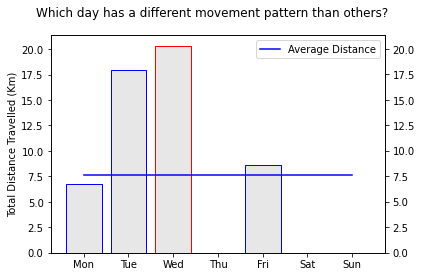

In [18]:
visualiser.plot_daywise_track(weekly_trajectories)